In [1]:
from aberrations import make_atm_data, make_1D_vibe_data, make_vibe_params
from observer import make_state_transition_vibe, make_kfilter_vibe, KFilter
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
from copy import deepcopy
%matplotlib inline

f_sampling = 1000
N_vibe = 10
steps = 5000

rms = lambda data: np.sqrt(np.mean(data ** 2))

In [2]:
#turb = make_atm_data(steps)[:,0]

In [3]:
vibes = np.zeros((N_vibe, steps))
vibe_params = np.zeros((N_vibe, 4))
# let's add in process noise so that there's something for Q to fit to!
process_vars = (10**-np.random.uniform(2, 4, (N_vibe,)))**2

In [4]:
for i in range(N_vibe):
    pars = make_vibe_params(N=1)
    vibes[i] = make_1D_vibe_data(steps, vib_params=pars, 
                                 N=1) + np.random.normal(0, process_vars[i], (steps,))
    vibe_params[i] = pars

In [5]:
truths = np.sum(vibes, axis=0)

(1e-07, 102.77953367008492)

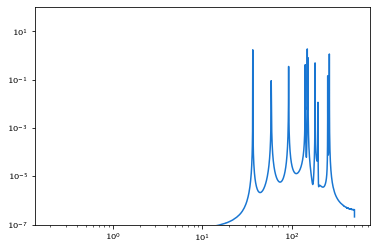

In [6]:
plt.loglog(*signal.periodogram(truths, fs=f_sampling))
plt.ylim(1e-7)

In [7]:
# let's assume we somehow constructed the 'perfect' A and Q.
# this is only the case for vibrations, because it's not really known what 'perfect turbulence control' would be.
# in any case, everything else is going to be put through the turbulence controller;
# the degeneracy I'm interested in is between different vibration modes.

kfilter = make_kfilter_vibe(vibe_params[:,1:3], process_vars)
state, A, P, Q, H, R = kfilter.get_params()
zero_state = deepcopy(state)
zero_measurement = np.zeros(R.shape[0])

# next, put P into a steady state!
iters = 0
while True:
    last_P = deepcopy(P)
    P = A.dot(P.dot(A.T)) + Q
    K = P.dot(H.T.dot(np.linalg.inv(H.dot(P.dot(H.T)) + R)))
    P -= K.dot(H.dot(P))
    if np.allclose(P, last_P):
        break
    iters += 1

print("Took %d iterations to get steady-state covariance." % iters)
kfilter.P = P
kfilter.set_gain()

Took 521 iterations to get steady-state covariance.


In [8]:
# and now, let's start with a zero state, drive it with white noise from Q,
# and hope that it converges to the truth states!

vibes_recorded = np.zeros((N_vibe, steps))
for i in range(steps):
    state = A.dot(state) + np.random.multivariate_normal(zero_state, Q)
    err = truths[i] + np.random.multivariate_normal(zero_measurement, R) - H.dot(state)
    state += kfilter.K.dot(err)
    for j in range(N_vibe):
        vibes_recorded[j][i] = state[2 * j]

In [9]:
def show_vibe_control(n=None):
    if n is None:
        truth = truths[iters:]
        recorded = np.sum(vibes_recorded, axis=0)[iters:]
    else:
        truth = vibes[n][iters:]
        recorded = vibes_recorded[n][iters:]
    plt.plot(truth, label='Truths')
    plt.plot(recorded, label='Kalman filtered')
    plt.plot(truth - recorded, label='Residual')
    plt.legend()
    plt.title("Pure-vibe control with white driving noise, rms = " + str(rms(truth - recorded)))
    plt.show()
    return truth, recorded

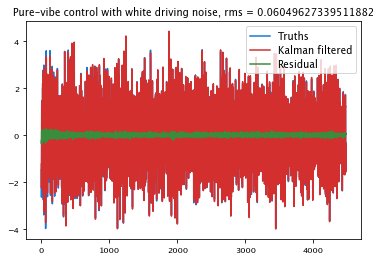

In [10]:
t, r = show_vibe_control()

(1e-07, 85.39949548425781)

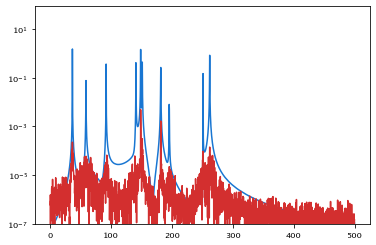

In [11]:
plt.semilogy(*signal.periodogram(t, fs=f_sampling))
plt.semilogy(*signal.periodogram(t - r, fs=f_sampling))
plt.ylim(1e-7)

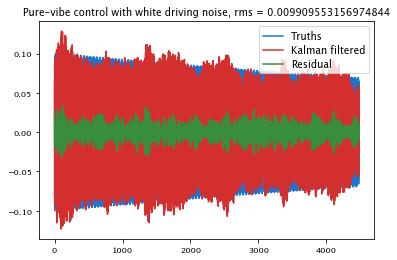

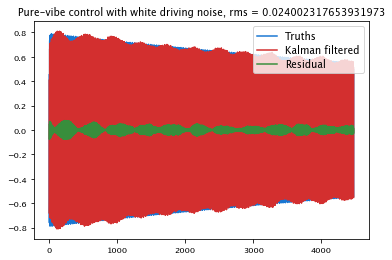

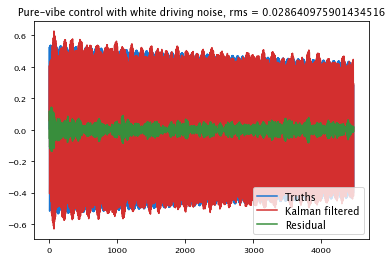

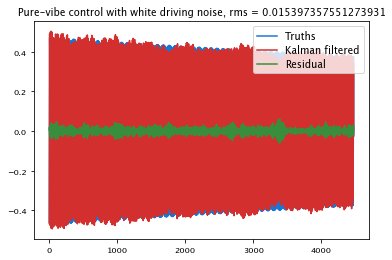

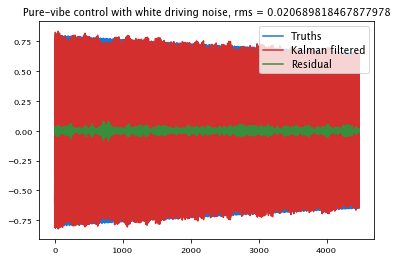

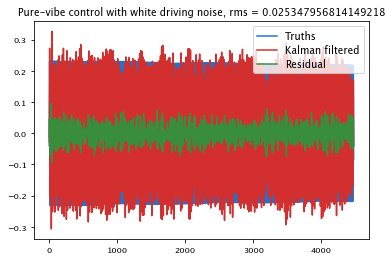

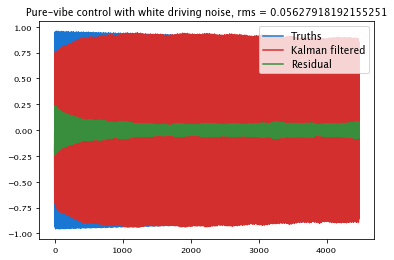

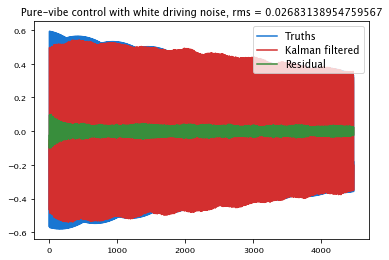

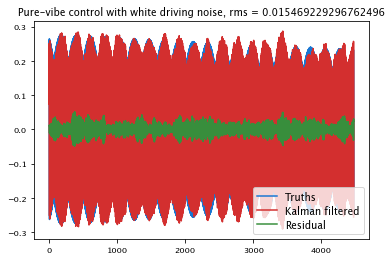

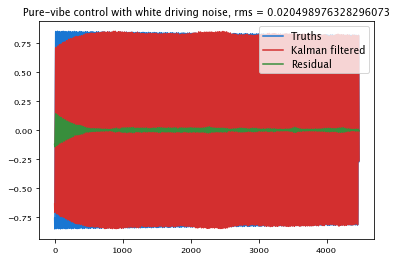

In [12]:
for i in range(N_vibe):
    show_vibe_control(i)